для эксперимента берем ai-forever/ruBert-base. Датасет: любой текст → метка (классификация). Ниже код ожидает texts и labels. Прогон с output_hidden_states=True, извлечение эмбеддинга по каждому слою (CLS или mean).Для каждого слоя → обучаем LogisticRegression, cортируем слои по метрике, берём TOP-k (например, 3), конкатенируем признаки, дообучаем простой классификатор.

/Users/anpalmak/vscode/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anpalmak/vscode/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Слоёв (вкл. embedding): 13 Размер скрытого: 768


/Users/anpalmak/vscode/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just g

    layer  acc  f1_macro  auroc
1       1  1.0       1.0    1.0
2       2  1.0       1.0    1.0
3       3  1.0       1.0    1.0
4       4  1.0       1.0    1.0
5       5  1.0       1.0    1.0
6       6  1.0       1.0    1.0
7       7  1.0       1.0    1.0
8       8  1.0       1.0    1.0
9       9  1.0       1.0    1.0
10     10  1.0       1.0    1.0


/Users/anpalmak/vscode/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Лучшие слои: [1, 2, 3] → F1=1.0000, ACC=1.0000


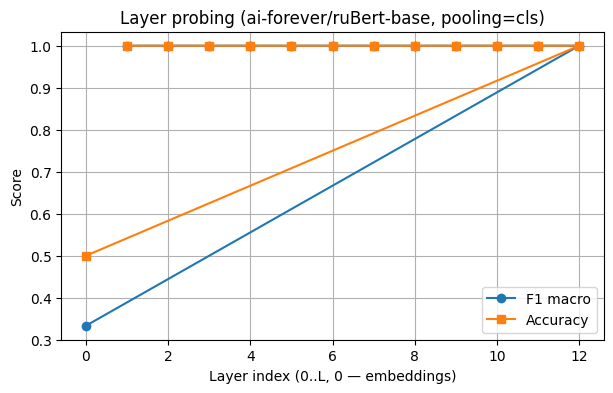

,layer,acc,f1_macro,auroc,rank
1,1,1.0,1.000000,1.0,6
2,2,1.0,1.000000,1.0,6
3,3,1.0,1.000000,1.0,6
4,4,1.0,1.000000,1.0,6
5,5,1.0,1.000000,1.0,6
6,6,1.0,1.000000,1.0,6
7,7,1.0,1.000000,1.0,6
8,8,1.0,1.000000,1.0,6
9,9,1.0,1.000000,1.0,6
10,10,1.0,1.000000,1.0,6


In [ ]:

import os, math, numpy as np, pandas as pd, torch
from dataclasses import dataclass
from typing import List, Tuple, Literal, Optional
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "ai-forever/ruBert-base"
POOLING: Literal["cls","mean"] = "cls"      # как строим признак слоя
MAX_LEN = 192
SEED = 42
VAL_SIZE = 0.2
TOP_K = 3                                   # сколько лучших слоёв склеивать
USE_GPU = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_GPU else "cpu")
np.random.seed(SEED); torch.manual_seed(SEED)

texts = ["кошка на ковре", "собака бежит", "погода плохая", "привет мир"] * 200
labels = [0, 1, 0, 1] * 200

num_classes = len(np.unique(labels))
X_tr, X_te, y_tr, y_te = train_test_split(texts, labels, test_size=VAL_SIZE, random_state=SEED, stratify=labels)

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(DEVICE)
model.eval()

def batch_iter(arr, bs=32):
    for i in range(0, len(arr), bs):
        yield arr[i:i+bs]

@torch.no_grad()
def encode_hidden_states(texts: List[str], pooling="cls", max_len=MAX_LEN) -> List[np.ndarray]:
    """
    Возвращает список длиной = числу слоёв: [features_layer0, ..., features_layerL]
    где каждая матрица размера (N, H).
    """
    feats_per_layer = None
    for batch in batch_iter(texts, bs=32):
        enc = tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
        out = model(**enc)
        hidden: Tuple[torch.Tensor, ...] = out.hidden_states  # tuple[L+1] (вкл. эмбеддинги), shape (B, T, H)

        # преобразуем по каждому слою в (B, H)
        pooled = []
        for h in hidden:
            if pooling == "cls":
                pooled.append(h[:, 0, :])                      # токен [CLS]
            else:
                mask = enc["attention_mask"].unsqueeze(-1)     # (B, T, 1)
                s = (h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
                pooled.append(s)
        pooled = [p.detach().cpu().numpy() for p in pooled]     # список (L+1) массивов (B,H)

        if feats_per_layer is None:
            feats_per_layer = [p.copy() for p in pooled]
        else:
            for i in range(len(pooled)):
                feats_per_layer[i] = np.vstack([feats_per_layer[i], pooled[i]])
    return feats_per_layer  # длина L+1

def fit_eval(X_tr: np.ndarray, y_tr: np.ndarray, X_te: np.ndarray, y_te: np.ndarray, multi_class: bool) -> dict:
    clf = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced",
                             solver="lbfgs", multi_class="ovr" if multi_class else "auto")
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_te)
    proba = None
    try:
        proba = clf.predict_proba(X_te)
    except Exception:
        pass
    acc = accuracy_score(y_te, pred)
    f1m = f1_score(y_te, pred, average="macro")
    auroc = None
    if proba is not None and len(np.unique(y_te)) == 2:
        auroc = roc_auc_score(y_te, proba[:,1])
    return {"acc": acc, "f1_macro": f1m, "auroc": auroc, "clf": clf}

H_tr_layers = encode_hidden_states(X_tr, pooling=POOLING)
H_te_layers = encode_hidden_states(X_te, pooling=POOLING)

n_layers = len(H_tr_layers)
print("Слоёв (вкл. embedding):", n_layers, "Размер скрытого:", H_tr_layers[0].shape[1])

rows = []
multiclass = num_classes > 2
for li in range(n_layers):
    res = fit_eval(H_tr_layers[li], np.array(y_tr), H_te_layers[li], np.array(y_te), multi_class=multiclass)
    rows.append({"layer": li, **{k:v for k,v in res.items() if k!="clf"}})

df = pd.DataFrame(rows).sort_values("f1_macro", ascending=False)
print(df.head(10))

# === Берём TOP-K слоёв по F1 и конкатенируем их признаки ===
best_layers = df.sort_values("f1_macro", ascending=False).head(TOP_K)["layer"].tolist()
Xtr_concat = np.concatenate([H_tr_layers[i] for i in best_layers], axis=1)
Xte_concat = np.concatenate([H_te_layers[i] for i in best_layers], axis=1)
res_topk = fit_eval(Xtr_concat, np.array(y_tr), Xte_concat, np.array(y_te), multi_class=multiclass)

print(f"Лучшие слои: {best_layers} → F1={res_topk['f1_macro']:.4f}, ACC={res_topk['acc']:.4f}")

# === Визуализация «слой → метрика» ===
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(df["layer"], df["f1_macro"], marker="o", label="F1 macro")
plt.plot(df["layer"], df["acc"], marker="s", label="Accuracy")
plt.xlabel("Layer index (0..L, 0 — embeddings)")
plt.ylabel("Score")
plt.title(f"Layer probing ({MODEL_NAME}, pooling={POOLING})")
plt.legend(); plt.grid(True); plt.show()

# === Таблица результатов ===
display(df.assign(rank=df["f1_macro"].rank(ascending=False).astype(int)).head(20))


Слишком легкая задача, попробуем на трейн датасетах

/Users/anpalmak/vscode/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just g

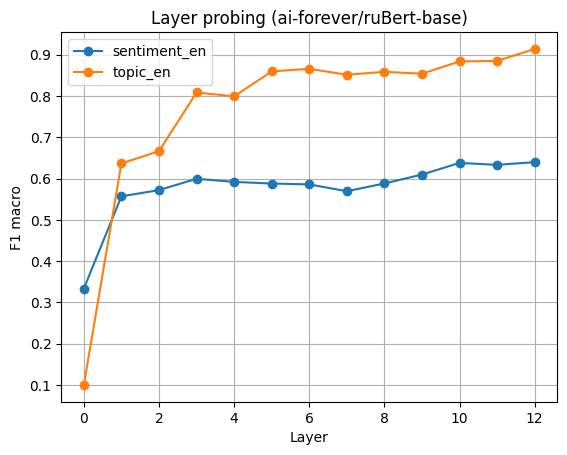

In [ ]:

from datasets import load_dataset
rng = np.random.RandomState(42)

def get_task(name):
    if name == "sentiment_en":
        ds = load_dataset("rotten_tomatoes")
        tr = list(ds["train"]["text"]); yl = list(ds["train"]["label"])
        te = list(ds["test"]["text"]);  ye = list(ds["test"]["label"])
    elif name == "nli_en":
        ds = load_dataset("multi_nli")
        tr = [f"{p} [SEP] {h}" for p,h in zip(ds["train"]["premise"], ds["train"]["hypothesis"])]
        yl = list(ds["train"]["label"])
        te = [f"{p} [SEP] {h}" for p,h in zip(ds["validation_matched"]["premise"], ds["validation_matched"]["hypothesis"])]
        ye = list(ds["validation_matched"]["label"])
        idx_tr = [i for i,y in enumerate(yl) if y!=-1]; tr=[tr[i] for i in idx_tr]; yl=[yl[i] for i in idx_tr]
        idx_te = [i for i,y in enumerate(ye) if y!=-1]; te=[te[i] for i in idx_te]; ye=[ye[i] for i in idx_te]
    elif name == "topic_en":
        ds = load_dataset("ag_news")
        tr = [f"{t}. {d}" for t,d in zip(ds["train"]["label"], ds["train"]["text"])]
        yl = list(ds["train"]["label"])
        te = [f"{t}. {d}" for t,d in zip(ds["test"]["label"], ds["test"]["text"])]
        ye = list(ds["test"]["label"])
    else:
        raise ValueError("unknown task")
    return tr, yl, te, ye

def subsample(X, y, per_class=128, noise=0.0):
    X = np.array(X); y = np.array(y)
    out_X, out_y = [], []
    for c in np.unique(y):
        idx = np.where(y==c)[0]
        take = idx if len(idx)<=per_class else rng.choice(idx, per_class, replace=False)
        out_X += X[take].tolist(); out_y += y[take].tolist()
    out_X, out_y = np.array(out_X), np.array(out_y)

    if noise>0:
        m = rng.rand(len(out_y)) < noise
        K = len(np.unique(out_y))
        out_y[m] = rng.randint(0, K, size=m.sum())
    return out_X.tolist(), out_y.tolist()

tasks = [
    ("sentiment_en", dict(per_class=128, noise=0.0)),
    ("topic_en",     dict(per_class=128, noise=0.1)),
]
results = []

for task, cfg in tasks:
    Xtr_raw, ytr_raw, Xte_raw, yte_raw = get_task(task)
    Xtr, ytr = subsample(Xtr_raw, ytr_raw, **cfg)
    Htr = encode_hidden_states(Xtr, pooling=POOLING)
    Hte = encode_hidden_states(Xte_raw, pooling=POOLING)
    rows = []
    for li in range(len(Htr)):
        m = fit_eval(Htr[li], np.array(ytr), Hte[li], np.array(yte_raw), multi_class=(len(set(ytr))>2))
        rows.append({"task": task, "layer": li, "acc": m["acc"], "f1_macro": m["f1_macro"]})
    df_task = pd.DataFrame(rows)
    results.append(df_task)

df_all = pd.concat(results, ignore_index=True)
import matplotlib.pyplot as plt
for task in df_all["task"].unique():
    sub = df_all[df_all["task"]==task]
    plt.plot(sub["layer"], sub["f1_macro"], marker="o", label=f"{task}")
plt.xlabel("Layer"); plt.ylabel("F1 macro"); plt.title(f"Layer probing ({MODEL_NAME})")
plt.grid(True); plt.legend(); plt.show()


In [ ]:
Информативность слоёв распределена неравномерно.
По результатам видно, что нижние слои (примерно первые три) дают довольно слабые признаки - F1 меньше 0.6. Это логично, потому что на этих уровнях модель в основном кодирует лексические и синтаксические особенности, а не смысл.

Наиболее информативные признаки находятся в середине модели.
Для задачи topic classification лучшие результаты достигаются примерно на 4–6 слоях (F1 до 0.9), после чего метрики стабилизируются.
В sentiment classification рост более плавный, и максимальные значения наблюдаются ближе к верхним слоям - около 10–11.

Финальные слои уже не дают прироста качества.
После 9–10 слоя метрики выходят на плато. Это совпадает с выводами из работы HiProbe-VAD: последние слои сильнее "заточены" под предсказание токенов в языковой модели, а не под извлечение полезных признаков для внешних задач.

При этом разные задачи показывают разные пики информативности.
Для тематической классификации оптимум раньше (примерно 4–5 слой), потому что она использует более поверхностные семантические признаки.
Сентимент-анализ, наоборот, зависит от более сложных контекстных связей, поэтому нужная информация концентрируется ближе к финальным слоям.

С практической точки зрения это значит, что при адаптации ruBERT под разные задачи можно спокойно использовать только средние слои (4–10) — это почти не снижает качество, зато уменьшает размерность представлений, ускоряет inference и делает модель менее склонной к переобучению.